In [1]:
import pandas as pd
import csv
from datetime import datetime
from nltk.corpus import stopwords
import re
import unidecode
import json
import os
import sys
import random
from collections import defaultdict
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from nltk import ngrams
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import numpy as np

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/yy452/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yy452/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yy452/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
def ws_tokenizer(text):
    return text.split()


text_processor = TextPreProcessor(
    normalize=[],
    annotate={},
    all_caps_tag="wrap",
    fix_text=True,
    segmenter="twitter_2018",
    corrector="twitter_2018",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # tokenizer=ws_tokenizer,
    dicts=[emoticons]
)

/home/yy452/anaconda3/lib/python3.8/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


/home/yy452/anaconda3/lib/python3.8/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [3]:

df1 = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/umd_reddit_suicidewatch_dataset_v2/expert/expert_posts.csv")
df2 = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/umd_reddit_suicidewatch_dataset_v2/expert/expert.csv")
final = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/sw/train_user_labels.csv")


In [4]:
df2.head()

,user_id,label
0,10090,c
1,10420,b
2,10940,c
3,11360,d
4,11388,c


In [3]:
final['label'].value_counts()

d    456
c    341
a    290
b    150
Name: label, dtype: int64

In [116]:
merged_data = pd.merge(df1, df2, on=['user_id'])
# merged_data = merged_data.drop(merged_data.columns[[1,2]], axis=1) 
# merged_data.to_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_c/combined_data_Task_C_Test.csv", index=False, encoding='utf-8')


In [73]:
merged_data.head()

,post_id,user_id,timestamp,subreddit,post_title,post_body,label
0,19kaxl,22941,1362288723,firstimpression,so what do you think im like?,NaN,d
1,19kvxm,22941,1362326434,NoStupidQuestions,What are fans of _PERSON_ called?,NaN,d
2,1a2amm,22941,1362974684,PokemonVGC,i want to get in to competitive pokémon playin...,so lately I've been playing the 3 versions of ...,d
3,1axicl,22941,1364156436,omegle,"just wondering, is it safe for me to use Omegl...",I want to use that feature but people are sayi...,d
4,1bwafu,22941,1365392923,MyLittleSupportGroup,"I'm still afraid of the dark, help.",I have been really afraid of the dark for a lo...,d


In [117]:
sw = merged_data.loc[merged_data['subreddit'] == "SuicideWatch"]
sw = sw.fillna(' ')
sw.head()

,post_id,user_id,timestamp,subreddit,post_title,post_body,label
28,1u6qxy,22941,1388617594,SuicideWatch,somebody please talk me out of this before i a...,i am in high school and i cant stand it. every...,d
38,1vzleb,22941,1390522384,SuicideWatch,dying would be so much better,for so long i thought that i could actually ge...,d
46,1zif0m,22941,1393917080,SuicideWatch,i want to commit suicide. but i cant.,I don't really know how to accurately describe...,d
48,2009p3,22941,1394411321,SuicideWatch,i should have died.,i had the perfect plan. i was going to commit ...,d
49,2074ou,22941,1394593008,SuicideWatch,overdosing,,d


In [118]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df
sw = df_column_switch(sw, 'timestamp', 'subreddit')

In [9]:
sw.to_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/sw/combined_data_sw.csv", index=False, encoding='utf-8')

In [20]:
sw['label'].value_counts()

c    162
d     93
b     77
a     45
Name: label, dtype: int64

In [119]:
merged_data =sw

In [113]:
# df1 = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/combined_data_Task_A.csv")
df1 = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/combined_data_Task_A_Test.csv")

df2 = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/trainUserIds_TaskA_Final.csv")


In [99]:
merged_data = pd.merge(df1, df2, on=['user_id'])
merged_data = merged_data.fillna(' ')
# merged_data.iloc[: , :-2].
# del merged_data['label_a']
merged_data

,post_id,user_id,subreddit,timestamp,post_title,post_body,label
0,2y8gli,40130,SuicideWatch,1425730607,Terrified my ex is attempting suicide right no...,"My ex has recently come off heroin, and had a ...",a
1,128hby,19368,SuicideWatch,1351456717,I'm getting better,I posted [this](_URL_ some amount of time ago....,a
2,248ojj,20841,SuicideWatch,1398736123,My mom's place of work is closing due to its f...,"Back in 2009, my mom was fired from her job af...",a
3,i399l,8720,SuicideWatch,1308443083,I apologize for not truly fitting into what a ...,"I have a friend (technically ex-girlfriend, th...",a
4,2uzcln,32730,SuicideWatch,1423229085,Philosophy about bullshit advice,I would like to go over my interpretation of s...,a
...,...,...,...,...,...,...,...
914,2jcwy9,49333,SuicideWatch,1413409674,Its too painful,Today was a personal low for me. My girlfriend...,d
915,2gchkg,36977,SuicideWatch,1410669113,I've lost everything I have worked for the pas...,"Hello, Im glad you are listening to me. I will...",d
916,2q1zhj,5196,SuicideWatch,1419239176,I overdosed? maybe..,When i feel suicidal i dont actively seek ways...,d
917,2xkei4,26915,SuicideWatch,1425223878,Help me to help my son,First here is some perspective- I am 51 years ...,d


In [24]:
merged_data[' label'].value_counts()

d    544
a    162
c    154
b     59
Name:  label, dtype: int64

In [19]:

vader = SentimentIntensityAnalyzer()

with open('/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Code/PreProcessing/contractions.json') as f:
    cList = json.load(f)

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

sw = stopwords.words("english")
extra_stop_words = ["cannot", "could", "would", "us", "may", "might", "need", "ought", "shall", "alls", "n't", "'s", "'ve", "'t", "'m", "'d", "'ll", "t"]
sw.extend(extra_stop_words)
#sw = []

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def humanize_unixtime(unix_time):
    time = datetime.fromtimestamp(int(unix_time)).strftime('%d-%m-%Y %H.%M')
    return time

def word_cleaner(word):
    word = unidecode.unidecode(word)
    if(word.lower() in sw):
        word = " "
    word = word.replace("_PERSON_", " ")
    word = word.replace("_IP_", " ")
    word = word.replace("_EMAIL_", " ")
    word = word.replace("_URL_", " ")
    word = word.replace("_person_", " ")
    word = word.replace("_ip_", " ")
    word = word.replace("_email_", " ")
    word = word.replace("_number_", " ")
    word = word.replace("_percent_", " ")
    word = word.replace("_money_", " ")
    word = word.replace("_time_", " ")
    word = word.replace("_date_", " ")
    word = word.replace("_url_", " ")
    word = word.replace(".", " ")
    p = re.compile('([A-Za-z]+)[.]')
    word = p.sub(r'\1 ', word)
    p = re.compile('[.]([A-Za-z]+)')
    word = p.sub(r' \1', word)
    word = word.replace("!", " ")
    word = word.replace(" r ", " ")
    word = word.replace(",", " ")
    word = word.replace("/", " ")
    word = word.replace("~", " ")
    word = word.replace("-", " ")
    word = word.replace("--", " ")
    word = word.replace("(", " ")
    word = word.replace(")", " ")
    word = word.replace("#", " ")
    word = word.replace("?", " ")
    word = word.replace("..", " ")
    word = word.replace("...", " ")
    word = word.replace("’", " ")
    word = word.replace(":", " ")
    word = word.replace("[", " ")
    word = word.replace("]", " ")
    word = word.replace("*", " ")
    word = word.replace("\"", " ")
    word = word.replace("&", " ")
    word = word.replace("{", " ")
    word = word.replace("}", " ")
    word = word.replace("@", " ")
    word = word.replace("↑", " ")
    word = word.replace("$", " ")
    word = word.replace("^", " ")
    word = word.replace("\n", " ")
    word = word.replace("\t", " ")
    word = word.replace("\r", " ")
    word = word.replace("`", " ")
    word = word.replace("'", " ")
    word = word.replace(";", " ")

#     word = word.replace("<number>", " ")
#     word = word.replace("<elongated>", " ")
#     word = word.replace("<hashtag>", " ")
#     word = word.replace("</hashtag>", " ")
#     word = word.replace("<emphasis>", " ")
#     word = word.replace("<repeated>", " ")
#     word = word.replace("<allcaps>", " ")
#     word = word.replace("</allcaps>", " ")
#     word = word.replace("<date>", " ")
#     word = word.replace("<time>", " ")
#     word = word.replace("<", " ")
#     word = word.replace(">", " ")
    if(word == "." or word == " ." or word == " . " or word == ". "):
        word = " "
    return word



In [69]:
merged_data = df1
merged_data.shape

(186, 6)

In [122]:
all_data = dict()
train_user_id_label = dict()
taskA_user_posts = defaultdict(list)
just_user_posts_train = list()
just_user_posts_test = list()
user_posts_for_fine_tuning_mlm = list()

count_len_before_g384 = dict()
count_len_before_l384 = dict()
count_len_after_g384 = dict()
count_len_after_l384 = dict()

for row_dict in merged_data.to_dict(orient="records"):
    print(row_dict)
    all_data[(row_dict['post_id'], row_dict['user_id'])] = row_dict
    train_user_id_label[row_dict['user_id']] = row_dict['label']
    taskA_user_posts[row_dict['user_id']].append(row_dict['post_id'])


{'post_id': '1u6qxy', 'user_id': 22941, 'subreddit': 'SuicideWatch', 'timestamp': 1388617594, 'post_title': 'somebody please talk me out of this before i actually make a plan', 'post_body': "i am in high school and i cant stand it. everyone expects me to be able to just deal with it, but i cant. i constantly feel horrible because i'm so easily triggered. there are so many things that i want to do but cant because of school or unacceptance or something stupid like that. its really starting to feel like i shouldn't go on. somebody please give me a reason. i really don't want to have to o it.", 'label': 'd'}
{'post_id': '1vzleb', 'user_id': 22941, 'subreddit': 'SuicideWatch', 'timestamp': 1390522384, 'post_title': 'dying would be so much better', 'post_body': "for so long i thought that i could actually get better. but every time i feel better, things just keep going downhill afterwards. i don't even know how to accurately describe how i feel. i always just slog through the school day thi

In [123]:
all_train_posts_of_users_combined = list()
all_train_posts_of_users_combined.append(["User ID", "Post", "Label"])
all_test_posts_of_users_combined = list()
all_test_posts_of_users_combined.append(["User ID", "Post"])



In [124]:
for user in taskA_user_posts:
    user_posts = list()
    for row in taskA_user_posts[user]:
        user_posts.append(all_data[(row, user)])
    posts_sorted_by_date = sorted(user_posts, key=lambda x : x['timestamp'], reverse=True)
    user_post_combined = ""
    for i, post in enumerate(posts_sorted_by_date):
        user_id = post['user_id']
        length = len(nltk.word_tokenize(post['post_title'])) + len(nltk.word_tokenize(post['post_body']))
        if length > 384 :
            if length in count_len_before_g384:
                count_len_before_g384[length] += 1
            else:
                count_len_before_g384[length] = 1
        else:
            if length in count_len_before_l384:
                count_len_before_l384[length] += 1
            else:
                count_len_before_l384[length] = 1
        post['post_title'] = " ".join(text_processor.pre_process_doc(post['post_title']))
        post['post_title'] = expandContractions(post['post_title'])
        post['post_title'] =' '.join(post['post_title'].split('\t'))
        post['post_title'] ='.'.join(post['post_title'].split('\n'))
        post['post_title'] =' '.join(post['post_title'].split('|'))
        post['post_title'] =' '.join(post['post_title'].split('\r'))
        
        post['post_body'] = " ".join(text_processor.pre_process_doc(post['post_body']))
        post['post_body'] = expandContractions(post['post_body'])
        post['post_body'] =' '.join(post['post_body'].split('\t'))
        post['post_body'] ='.'.join(post['post_body'].split('\n'))
        post['post_body'] =' '.join(post['post_body'].split('|'))
        post['post_body'] =' '.join(post['post_body'].split('\r'))
        
        word_tokenized_title = nltk.word_tokenize(post['post_title'])
        word_tokenized_post = nltk.word_tokenize(post['post_body'])
        one_post = ""
        for word in word_tokenized_title:
            user_post_combined += word_cleaner(word) + " "
            one_post += word_cleaner(word) + " "
        
        for word in word_tokenized_post:
            user_post_combined += word_cleaner(word) + " "
            one_post += word_cleaner(word) + " "
            
        length = len(nltk.word_tokenize(one_post))
        if length > 384 :
            if length in count_len_after_g384:
                count_len_after_g384[length] += 1
            else:
                count_len_after_g384[length] = 1
        else:
            if length in count_len_after_l384:
                count_len_after_l384[length] += 1
            else:
                count_len_after_l384[length] = 1
            
    user_post_combined = re.sub(' +', ' ', user_post_combined)
    #user_post_combined = ' '.join(user_post_combined.split(' '))
    user_post_combined = user_post_combined.strip()
    user_post_combined = user_post_combined.lower()
    for sent in nltk.sent_tokenize(user_post_combined):
        user_posts_for_fine_tuning_mlm.append(sent)
    user_posts_for_fine_tuning_mlm.append(None)
    #print(user_post_combined)
    #print("\n\n\n")
    #label = random.randint(0,1)
    if user in train_user_id_label:
        label = train_user_id_label[user]
        all_train_posts_of_users_combined.append([user_id, user_post_combined, label])
        just_user_posts_train.append(user_post_combined)
    else:
        label = test_user_id_label[user]
        all_test_posts_of_users_combined.append([user_id, user_post_combined, label])
        just_user_posts_test.append(user_post_combined)

with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add/User_Posts_Processed_Train_Full_Final.tsv",'w', encoding = 'utf8', newline='') as outcsv:   
    writer = csv.writer(outcsv, delimiter='\t',quotechar = '"')
    for row in all_train_posts_of_users_combined:
        writer.writerow(row)


In [114]:
path ="/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/combined_data_Task_A_Test.csv"
all_data = dict()
file = open(path, 'r', encoding = 'utf8')
reader_data = csv.reader(file)
for i, row in enumerate(reader_data):
    if(i == 0):
        continue
    all_data[(row[0], row[1])] = row
all_test_posts_of_users_combined = list()
all_test_posts_of_users_combined.append(["User ID", "Post"])


taskA_path ="/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/umd_reddit_suicidewatch_dataset_v2/crowd/test/task_A_test.posts.csv"
file =open(taskA_path, 'r', encoding = 'utf8')
reader_user = csv.reader(file, delimiter=',')
taskA_user_posts = defaultdict(list)
for i, row in enumerate(reader_user):
    if(i == 0):
        continue
    taskA_user_posts[row[1]].append(row[0])

print(len(taskA_user_posts))
for user in taskA_user_posts:
    user_posts = list()
    for row in taskA_user_posts[user]:
        user_posts.append(all_data[(row, user)])
    posts_sorted_by_date = sorted(user_posts, key=lambda x : x[3], reverse=True)
    # for row in sorted_by_date:
    #     row[2] = humanize_unixtime(row[2])
    # sorted_by_date
    user_post_combined = ""
    for i, post in enumerate(posts_sorted_by_date):
        user_id = post[1]
        post[4] = " ".join(text_processor.pre_process_doc(post[4]))

        post[4] = expandContractions(post[4])
        post[4] =' '.join(post[4].split('\t'))
        post[4] ='.'.join(post[4].split('\n'))
        post[4] =' '.join(post[4].split('|'))
        post[4] =' '.join(post[4].split('\r'))
        
        post[5] = " ".join(text_processor.pre_process_doc(post[5]))

        post[5] = expandContractions(post[5])
        post[5] =' '.join(post[5].split('\t'))
        post[5] ='.'.join(post[5].split('\n'))
        post[5] =' '.join(post[5].split('|'))
        post[5] =' '.join(post[5].split('\r'))
        
        #user_post_title = nltk.sent_tokenize(post[4])
        #user_post = nltk.sent_tokenize(post[5])
        
        #final_post_title_sentiment = ""
        #final_post_sentiment = ""
        
        #for sent in user_post_title:
        #    mydict = vader.polarity_scores(sent)
        #    if(mydict['compound'] <= -0.05 or mydict['compound'] >= 0.05):
        #        final_post_title_sentiment += sent
                
        #for sent in user_post:
        #    mydict = vader.polarity_scores(sent)
        #    if(mydict['compound'] <= -0.05 or mydict['compound'] >= 0.05):
        #        final_post_sentiment += sent
        
        word_tokenized_title = nltk.word_tokenize(post[4])
        word_tokenized_post = nltk.word_tokenize(post[5])
        #word_tokenized_title = nltk.word_tokenize(final_post_title_sentiment)
        #word_tokenized_post = nltk.word_tokenize(final_post_sentiment)
        
        for word in word_tokenized_title:
            user_post_combined += word_cleaner(word) + " "
        
        for word in word_tokenized_post:
            user_post_combined += word_cleaner(word) + " "
            
    user_post_combined = re.sub(' +', ' ',user_post_combined)
    #user_post_combined = ' '.join(user_post_combined.split(' '))
    user_post_combined = user_post_combined.strip()
    user_post_combined = user_post_combined.lower()
    #print(user_post_combined)
    #print("\n\n\n")
    #label = random.randint(0,1)
    #if user in train_user_id_label:
    #    label = train_user_id_label[user]
    #    all_train_posts_of_users_combined.append([user_id, user_post_combined, label])
    #else:
    #    label = test_user_id_label[user]
    #    all_test_posts_of_users_combined.append([user_id, user_post_combined, label])
    all_test_posts_of_users_combined.append([user_id, user_post_combined])

with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/emoticons_add/Full_Test_Data.tsv",'w', encoding = 'utf8', newline='') as outcsv:   
        writer = csv.writer(outcsv, delimiter='\t', quotechar = '"')
        for row in all_test_posts_of_users_combined:
            writer.writerow(row)

125


In [131]:
req = list()
for i in range(1, 1001):
    req.append(i)
req_final = random.sample(req,  100)
train_set = list()
dev_set = list()


In [132]:
user_posts_final = []
with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add/User_Posts_Processed_Train_Full_Final.tsv",'r', encoding = 'utf8', newline='') as outcsv:   
        reader = csv.reader(outcsv, delimiter='\t',quotechar = '"')
        for row in reader:
            user_posts_final.append(row)
        
for i, row in enumerate(user_posts_final):
    if(i == 0):
        header = row
    elif(i in req_final):
        dev_set.append(row)
    else:
        train_set.append(row)


In [133]:
with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add/User_Posts_Processed_Train_Final.tsv",'w', encoding = 'utf8', newline='') as outcsv:   
        writer = csv.writer(outcsv, delimiter="\t", quotechar=None)
        writer.writerow(header)
        for row in train_set:
            writer.writerow(row)
            
with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add/User_Posts_Processed_Dev_Final.tsv",'w', encoding = 'utf8', newline='') as outcsv:   
        writer = csv.writer(outcsv, delimiter="\t", quotechar=None)
        writer.writerow(header)
        for row in dev_set:
            writer.writerow(row)


## oversampling

In [130]:
users = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add/User_Posts_Processed_Train_Full_Final.tsv", sep='\t', header=0)
users['Label'].value_counts()
# users


c    250
b    250
a    250
d    250
Name: Label, dtype: int64

In [129]:
# -*- coding: utf-8 -*-
"""
Oversampling Class B Samples to Class A
"""

csv.field_size_limit(sys.maxsize)
#user_posts = list()
user_posts_final = list()
with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add/User_Posts_Processed_Train_Full_Final.tsv",'r', encoding = 'utf8', newline='') as outcsv:   
        reader = csv.reader(outcsv, delimiter='\t',quotechar = '"')
        for row in reader:
            user_posts_final.append(row)
    
#with open("C:\\CLPsych Challenge\\Dataset\\PreProcessing\\Non-PreProcessed-Data\\User_Posts_Processed_Train_Full_Final.tsv",'r', encoding = 'utf8', newline='') as outcsv:   
#        reader = csv.reader(outcsv, delimiter='\t',quotechar = '"')
#        for row in reader:
#            user_posts.append(row)

# typeOfSampling = Over or Under Sampling the Data. 0 for undersample, 1 for oversample)
# num_samples_to_change = Number of samples to add or remove
# class_name = the class you want to sample.            
def over_under_sample(posts, class_name, typeOfSampling, num_samples_to_change):
    edited_posts = []
    temp_posts = []
    req = []
    for row in posts:
        if(row[2] == class_name):
            temp_posts.append(row)
        else:
            edited_posts.append(row)
    random.seed(10)
    if(typeOfSampling == 0):
        for i in range(0, len(temp_posts)):
            req.append(i)
        req_final = random.sample(req, len(temp_posts) - num_samples_to_change)
        for i in req_final:
            edited_posts.append(temp_posts[i])
    else:
        edited_posts.extend(temp_posts)
        while num_samples_to_change - len(temp_posts) > 0:
            edited_posts.extend(temp_posts)
            num_samples_to_change -= len(temp_posts)
        while(num_samples_to_change > 0):
            num = random.randint(0, len(temp_posts))
            edited_posts.append(temp_posts[num])
            num_samples_to_change -= 1
    return edited_posts
        
#user_posts_undersampled = over_under_sample(user_posts_final, 'd', 0, 149 - 85)
# user_posts_oversampled = over_under_sample(user_posts_final, 'b', 1, 250-177)
user_posts_oversampled = over_under_sample(user_posts_final, 'a', 1, 250-163)
# user_posts_oversampled = over_under_sample(user_posts_final, 'c', 1, 250-228)  

count_label_class = dict()
for row in user_posts_oversampled:
    if(row[2] in count_label_class):
        count_label_class[row[2]] += 1
    else:
        count_label_class[row[2]] = 1

with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add/User_Posts_Processed_Train_Full_Final.tsv",'w', encoding = 'utf8', newline='') as outcsv:   
        writer = csv.writer(outcsv, delimiter='\t', quotechar = '"')
        for row in user_posts_oversampled:
            writer.writerow(row)

In [64]:
oversampled = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/sw_oversampled/User_Posts_Processed_Train_Full_Final.tsv", sep='\t', header=0)
oversampled['Label'].value_counts()

c    250
b    250
a    250
d    250
Name: Label, dtype: int64

In [32]:
output_dir = "/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add"
input_file = "/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add/User_Posts_Processed_Train_Full_Final.tsv"
lines = []
with open(input_file, "r") as f:
    reader = csv.reader(f, delimiter="\t", quotechar=None)
    for line in reader:
        if sys.version_info[0] == 2:
            line = list(unicode(cell, 'utf-8') for cell in line)
        lines.append(line)

# 10-fold-cross-validation

In [2]:
from sklearn.model_selection import KFold
import sys
n=10
kf = KFold(n_splits=n, random_state=42, shuffle=True)
kf

KFold(n_splits=10, random_state=42, shuffle=True)

In [3]:
output_dir = "/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add/10_fold"
input_file = "/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/add_expert/emoticons_add/User_Posts_Processed_Train_Full_Final.tsv"
lines = []
with open(input_file, "r") as f:
    reader = csv.reader(f, delimiter="\t", quotechar=None)
    for line in reader:
        if sys.version_info[0] == 2:
            line = list(unicode(cell, 'utf-8') for cell in line)
        lines.append(line)
lines


[['User ID', 'Post', 'Label'],
 ['22941',
  'get ive posted tomes hope guys annoyed anyways sounds weird really want die much really wish live pain good life find happiness things seems impossible feel trapped constantly thinking ways like talking people feelings irl make fun especially mom want call suicide hotline really really scared calling people anxiety im scared track something throw mental hospital like 3 months clean self harm really wan na go back road way wait another 4 + years waiting life deeply thinking suicide say bunch different posts thing gets worse every day try talk people keep saying talk therapists keep trying stuff like attempt suicide march worked unfortunately end trying ill certainly make sure works said want die want escape suicide way really really want know anyone knows escape please help actually want escape go therapist get accommodations medicine something keep talking people fucking trying getting anywhere whatever help pretty soon far tired waiting wai

In [4]:
fold = 1

for train_ind, val_ind in kf.split(lines):
    train_set = list()
    dev_set = list()
    for i, row in enumerate(lines):
        if(i == 0):
            header = row
        elif(i in val_ind):
            dev_set.append(row)
        else:
            train_set.append(row)
    with open(os.path.join(output_dir, "User_Posts_Processed_Train_Final_{}.tsv".format(fold)),'w', encoding = 'utf8', newline='') as outcsv:   
        writer = csv.writer(outcsv, delimiter="\t", quotechar=None)
        writer.writerow(header)
        for row in train_set:
            writer.writerow(row)
            
    with open(os.path.join(output_dir, "User_Posts_Processed_Dev_Final_{}.tsv".format(fold)),'w', encoding = 'utf8', newline='') as outcsv:   
        writer = csv.writer(outcsv, delimiter="\t", quotechar=None)
        writer.writerow(header)
        for row in dev_set:
            writer.writerow(row)
              
    fold += 1

# word cloud

In [7]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/User_Posts_Processed_Train_Final.tsv", sep='\t', header=0)
# df2 = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/trainUserIds_TaskA_Final.csv")
# df = pd.merge(df1, df2, on=['user_id'])
# df = df.fillna(' ')
df

,User ID,Post,Label
0,40130,terrified ex attempting suicide right another ...,a
1,19368,getting better posted amount time ago story gu...,a
2,20841,mom place work closing due financial failure p...,a
3,32730,philosophy bullshit advice like go interpretat...,a
4,19994,something distract know write really writing g...,a
...,...,...,...
511,40424,little lost feel lost right trouble work freak...,b
512,30566,seems really logical commit suicide life many ...,b
513,16955,reddit nee help girlfriend scared going kill e...,b
514,5169,alone recently depressed one talk family shun ...,b


In [15]:
# df['post'] = df['post_body'] + df['post_title']
grouped = df.groupby(['Label'])['Post'].apply(','.join).reset_index()
grouped

,Label,Post
0,a,terrified ex attempting suicide right another ...
1,b,nobody seems understand lost 120+lbs got fat c...
2,c,wish balls told suicide selfish yet think ever...
3,d,really look forward alive next 50 years depres...


In [8]:
def process_text(text):
#     text = expandContractions(text)
#     text = word_cleaner(text)
    words_to_remove = ["tl dr", 'wan na', "gon na", "don t", 'year old']
    for word in words_to_remove:
        text = text.replace(word, "")
    return text

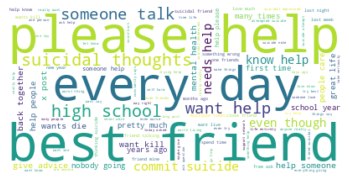

[('best friend', 11),
 ('please help', 11),
 ('every day', 9),
 ('suicidal thoughts', 7),
 ('high school', 7),
 ('someone talk', 6),
 ('want help', 6),
 ('commit suicide', 6),
 ('even though', 5),
 ('know help', 5),
 ('needs help', 5),
 ('give advice', 5),
 ('wants die', 5),
 ('help someone', 5),
 ('want kill', 5),
 ('mental health', 5),
 ('x post', 5),
 ('back together', 5),
 ('first time', 4),
 ('pretty much', 4),
 ('nobody going', 4),
 ('school year', 4),
 ('many times', 4),
 ('years ago', 4),
 ('help people', 4),
 ('people care', 4),
 ('great life', 4),
 ('someone help', 4),
 ('help please', 4),
 ('something wrong', 4),
 ('months ago', 4),
 ('multiple times', 4),
 ('last night', 4),
 ('want live', 4),
 ('free ask', 4),
 ('friend mine', 4),
 ('one friends', 4),
 ('help know', 4),
 ('suicidal friend', 4),
 ('last week', 4),
 ('wants kill', 4),
 ('thinking suicide', 4),
 ('friend talking', 4),
 ('love much', 4),
 ('spend time', 4),
 ('new year', 4),
 ('close friend', 4),
 ('time life'

In [48]:
text = process_text(grouped['Post'][0])
wordcloud = WordCloud(background_color="white", collocation_threshold = 2).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

freqs = WordCloud(collocation_threshold = 2).process_text(text)
words = []
for key, value in freqs.items():
    words.append((key, value))
words.sort(key=lambda x: x[1], reverse=True)
words

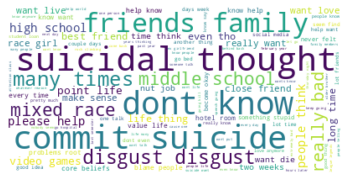

[('suicidal thought', 19),
 ('commit suicide', 18),
 ('dont know', 17),
 ('friends family', 12),
 ('many times', 12),
 ('disgust disgust', 12),
 ('middle school', 12),
 ('mixed race', 12),
 ('really bad', 11),
 ('please help', 11),
 ('people think', 11),
 ('high school', 11),
 ('video games', 10),
 ('point life', 10),
 ('life thing', 10),
 ('long time', 10),
 ('best friend', 10),
 ('even tho', 10),
 ('really want', 9),
 ('want live', 9),
 ('want love', 9),
 ('close friend', 9),
 ('make sense', 9),
 ('race girl', 9),
 ('want die', 8),
 ('time think', 8),
 ('two weeks', 8),
 ('nut job', 8),
 ('blame people', 8),
 ('value life', 8),
 ('every time', 8),
 ('problems root', 8),
 ('core beliefs', 8),
 ('hotel room', 8),
 ('help know', 8),
 ('know want', 8),
 ('know help', 8),
 ('something stupid', 8),
 ('become okay', 8),
 ('never felt', 8),
 ('another thing', 8),
 ('dont even', 8),
 ('days week', 8),
 ('seem find', 7),
 ('one talk', 7),
 ('go bed', 7),
 ('help want', 7),
 ('lot time', 7),
 (

In [50]:
text = process_text(grouped['Post'][1])
# text = grouped['Post'][1]
wordcloud = WordCloud(background_color="white", collocation_threshold = 2).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

freqs = WordCloud(collocation_threshold = 2).process_text(text)
words = []
for key, value in freqs.items():
    words.append((key, value))
words.sort(key=lambda x: x[1], reverse=True)
words

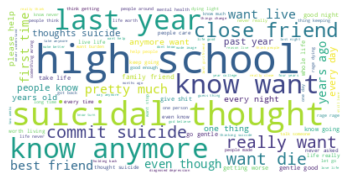

[('high school', 23),
 ('suicidal thought', 14),
 ('know anymore', 10),
 ('last year', 10),
 ('know want', 10),
 ('close friend', 10),
 ('commit suicide', 9),
 ('really want', 9),
 ('want die', 9),
 ('pretty much', 9),
 ('want live', 9),
 ('best friend', 9),
 ('first time', 8),
 ('even though', 8),
 ('years ago', 8),
 ('thoughts suicide', 7),
 ('every day', 7),
 ('people know', 7),
 ('past year', 7),
 ('every night', 6),
 ('one thing', 6),
 ('anymore want', 6),
 ('years old', 6),
 ('please help', 6),
 ('family friend', 6),
 ('getting worse', 5),
 ('take life', 5),
 ('know going', 5),
 ('go gentle', 5),
 ('gentle good', 5),
 ('good night', 5),
 ('give shit', 5),
 ('whole life', 5),
 ('thought suicide', 5),
 ('never asked', 5),
 ('live life', 5),
 ('every time', 5),
 ('people care', 5),
 ('worth living', 5),
 ('keep going', 5),
 ('life really', 5),
 ('even know', 5),
 ('one person', 4),
 ('think getting', 4),
 ('know never', 4),
 ('talk someone', 4),
 ('people made', 4),
 ('rage rage', 4

In [46]:
text = process_text(grouped['Post'][2])

wordcloud = WordCloud(background_color="white",collocation_threshold = 2).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

freqs = WordCloud(collocation_threshold = 2).process_text(text)
words = []
for key, value in freqs.items():
    words.append((key, value))
words.sort(key=lambda x: x[1], reverse=True)
words

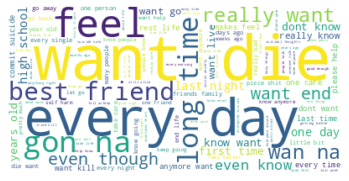

In [47]:
text = grouped['Post'][3]
wordcloud = WordCloud(background_color="white",collocation_threshold = 2).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [101]:
freqs = WordCloud(collocation_threshold = 3).process_text(text)
words = []
for key, value in freqs.items():
    words.append((key, value))
words.sort(key=lambda x: x[1], reverse=True)
words

[('want', 590),
 ('know', 446),
 ('feel', 370),
 ('life', 361),
 ('think', 285),
 ('people', 238),
 ('time', 234),
 ('one', 230),
 ('going', 211),
 ('now', 199),
 ('go', 190),
 ('friend', 190),
 ('even', 189),
 ('thing', 187),
 ('make', 168),
 ('way', 161),
 ('help', 156),
 ('anymore', 149),
 ('kill', 145),
 ('end', 145),
 ('day', 144),
 ('much', 140),
 ('will', 138),
 ('really', 137),
 ('live', 132),
 ('die', 131),
 ('love', 129),
 ('thought', 129),
 ('never', 123),
 ('work', 121),
 ('family', 120),
 ('see', 120),
 ('better', 119),
 ('need', 116),
 ('everything', 113),
 ('year', 112),
 ('hate', 111),
 ('talk', 109),
 ('still', 106),
 ('say', 104),
 ('take', 99),
 ('nothing', 97),
 ('world', 95),
 ('anything', 90),
 ('point', 87),
 ('told', 87),
 ('wanted', 86),
 ('tell', 85),
 ('job', 84),
 ('someone', 82),
 ('back', 81),
 ('care', 80),
 ('lot', 80),
 ('give', 79),
 ('everyone', 78),
 ('made', 78),
 ('anyone', 77),
 ('tired', 76),
 ('parent', 76),
 ('happy', 75),
 ('got', 72),
 ('pain

In [48]:
from nltk.util import ngrams 
from collections import Counter

all_words = []
text = grouped['Post'][0]

for i in range(1,4):
    freq = Counter(ngrams(text.split(), i))
    all_words.extend(freq.most_common())

all_words.sort(key=lambda x: x[1], reverse=True)
all_words

[(('feel', 'like'), 22),
 (('get', 'better'), 12),
 (('every', 'day'), 10),
 (('felt', 'like'), 9),
 (('best', 'friend'), 8),
 (('tl', 'dr'), 8),
 (('suicidal', 'thoughts'), 7),
 (('r', 'suicidewatch'), 7),
 (('wan', 'na'), 7),
 (('please', 'help'), 7),
 (('commit', 'suicide'), 7),
 (('even', 'though'), 6),
 (('high', 'school'), 6),
 (('years', 'ago'), 6),
 (('needs', 'help'), 6),
 (('last', 'night'), 6),
 (('get', 'back'), 6),
 (('feel', 'free'), 6),
 (('mental', 'health'), 6),
 (('close', 'friends'), 6),
 (('thinking', 'suicide'), 6),
 (('things', 'like'), 5),
 (('days', 'ago'), 5),
 (('many', 'times'), 5),
 (('know', 'help'), 5),
 (('wants', 'die'), 5),
 (('want', 'kill'), 5),
 (('people', 'care'), 5),
 (('trying', 'get'), 5),
 (('it', 'i'), 5),
 (('wants', 'kill'), 5),
 (('back', 'together'), 5),
 (('first', 'time'), 4),
 (('pretty', 'much'), 4),
 (('alone', 'i'), 4),
 (('nobody', 'going'), 4),
 (('someone', 'talk'), 4),
 (('r', 'depression'), 4),
 (('want', 'help'), 4),
 (('help',

In [11]:
df = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/Full_Train_Data_Final.tsv", sep='\t', header=0)
df


,User ID,Post,Label
0,40130,terrified ex attempting suicide right another ...,a
1,19368,getting better posted amount time ago story gu...,a
2,20841,mom place work closing due financial failure p...,a
3,8720,apologize truly fitting poster supposed friend...,a
4,32730,philosophy bullshit advice like go interpretat...,a
...,...,...,...
568,40424,little lost feel lost right trouble work freak...,b
569,30566,seems really logical commit suicide life many ...,b
570,16955,reddit nee help girlfriend scared going kill e...,b
571,5169,alone recently depressed one talk family shun ...,b


In [13]:
# df.loc[df['Label'] == 'b', 'Label'] = "a"
# df.loc[df['Label'] == 'c', 'Label'] = "d"

df.drop(df.loc[df['Label']=='b'].index, inplace=True)

In [14]:
df

,User ID,Post,Label
127,42997,wish balls told suicide selfish yet think ever...,c
128,981,point existence know always depression sometim...,c
129,2205,thoughts suicide ever accepted society hello e...,c
130,49779,nothing left lost faith hope anything ever bel...,c
131,35819,nihilist teetering edge things good came,c
...,...,...,...
441,49333,painful today personal low girlfriend hit bad ...,d
442,36977,lost everything worked past 5 years hello im g...,d
443,5196,overdosed maybe feel suicidal dont actively se...,d
444,26915,help help son first perspective- 51 years age ...,d


In [15]:
import random
import sys
import csv
req = list()
for i in range(0, 319):
    req.append(i)
req_final = random.sample(req,  32)
train_set = list()
dev_set = list()


with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/cd_binary/User_Posts_Processed_Train_Full_Final.tsv",'w', encoding = 'utf8', newline='') as outcsv:   
    writer = csv.writer(outcsv, delimiter='\t',quotechar = '"')
    for i, row in df.iterrows():
        writer.writerow(row)
        
        
with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/cd_binary/User_Posts_Processed_Train_Final.tsv",'w', encoding = 'utf8', newline='') as outcsv:   
        writer = csv.writer(outcsv, delimiter="\t", quotechar=None)
#         writer.writerow(header)
        for i,row in df.iterrows():
            if i not in req_final:
                writer.writerow(row)
            
with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/cd_binary/User_Posts_Processed_Dev_Final.tsv",'w', encoding = 'utf8', newline='') as outcsv:   
        writer = csv.writer(outcsv, delimiter="\t", quotechar=None)
#         writer.writerow(header)
        for i,row in df.iterrows():
            if i in req_final:
                writer.writerow(row)

# combined data for multi-layer model

In [2]:
# high = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/output/task_a/longformer_binary/longformer_a.csv")
abcd = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/output/task_a/longformer_ab_cd/longformer_urgent.csv")
ab = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/output/task_a/longformer_ab_cd/longformer_ab.csv")
cd = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/output/task_a/longformer_ab_cd/longformer_cd.csv")

# gold = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/umd_reddit_suicidewatch_dataset_v2/crowd/test/crowd_test_A.csv")

In [3]:
ab.drop(ab.loc[abcd['results']==1].index, inplace=True)
cd.drop(cd.loc[abcd['results']==0].index, inplace=True)
# ab.loc[abcd['results'] == 1  , 'results'] = 1
# high.loc[abc['results'] == 2  , 'results'] = 2
cd.loc[cd['results'] == 1 , 'results'] = 3
cd.loc[cd['results'] == 0  , 'results'] = 2


In [9]:

abc['results'].value_counts()

3    61
0    40
2    22
1     2
Name: results, dtype: int64

In [6]:
with open("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/output/task_a/longformer_ab_cd/combined.csv",'a+', encoding = 'utf8', newline='') as outcsv:   
        writer = csv.writer(outcsv, quotechar=None)
#         writer.writerow(header)
        for i,row in cd.iterrows():
            writer.writerow(row)

# check pronoun

In [3]:
labels = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/testUserIds_TaskA_Final.csv")
df = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/combined_data_Task_A_Test.csv")
# labels = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/trainUserIds_TaskA_Final.csv")
# df = pd.read_csv("/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/Dataset/task_a/combined_data_Task_A.csv")

In [4]:
labeled  = pd.merge(labels, df, on=['user_id'])

In [5]:
labeled['post'] = labeled['post_title'] + labeled['post_body']
labeled

,user_id,label,post_id,subreddit,timestamp,post_title,post_body,post
0,35972,a,t2bsu,SuicideWatch,1335914865,"As suggested by a fellow redditor, I have reco...","I just finished recording it. Ah, I'm actually...","As suggested by a fellow redditor, I have reco..."
1,6789,a,1ndbl6,SuicideWatch,1380455010,The chest ache,The struggle to not cry and the chest pain wit...,The chest acheThe struggle to not cry and the ...
2,30606,a,tkm7p,SuicideWatch,1336885504,Anyone around,anyone here that ll talk to me for a little wh...,Anyone aroundanyone here that ll talk to me fo...
3,50962,a,20p9qp,SuicideWatch,1395125976,23% of my life I've lived and I wish I hadn't,I'm utterly incapable of accomplishing anythin...,23% of my life I've lived and I wish I hadn'tI...
4,49555,a,2gkq2f,SuicideWatch,1410887230,Worried about a friend,I had a friend confess to me that he had writt...,Worried about a friendI had a friend confess t...
...,...,...,...,...,...,...,...,...
181,28148,d,2tro0t,SuicideWatch,1422309575,Looking for peace,I've been struggling with bipolar depression f...,Looking for peaceI've been struggling with bip...
182,28148,d,2u4wgg,SuicideWatch,1422573313,Guilt,I attempted just a couple of days ago and am n...,GuiltI attempted just a couple of days ago and...
183,28152,d,1udbrm,SuicideWatch,1388811052,The feeling of never being able to please ever...,I'm the kind of person that likes to see other...,The feeling of never being able to please ever...
184,28152,d,2qlb67,SuicideWatch,1419740892,My biggest concern is that I might go out on a...,Things haven't been looking up as of late. Hav...,My biggest concern is that I might go out on a...


In [6]:
# prp_dict = {1: ['i feel', "i want", 'i wanted', 'i can', 'i could', 'i did', 'i cant', 'i do', 'i am', 'i was', 'myself', 'my life'],
#        3: ['he',  'she', 'herself', 'himself', 'my friend', 'best friend']}

#(21,1b)
# prp_dict = {1: ['i feel', "i want", 'i wanted', 'i can', 'i could', 'i cant', 'i am', 'i was', 'myself', 'my life'],
#        3: ['he felt', 'he feels','i miss', 'he wanted', 'he wants', 'she wants', 'she felt', 'she feels', 'she wanted', 'herself', 'himself','my friend', 'best friend']}

#(31, b)
prp_dict = {1: ['i feel', "i want", 'i wanted', 'i can', 'i could', 'i cant', 'myself', 'my life'],
       3: ['they felt','they feels', 'they wanted', 'they wants','kill themself', 'i miss', 'he felt', 'he feels','he has','he wants', 'he wanted', 'she wants','she has', 'she felt', 'she feels', 'she wanted', 'herself', 'himself', 'my friend', 'best friend']}

def count_prps(post):
    texts = nltk.word_tokenize(post)
    
    prps = dict()
    for word in texts:
        word = word.lower()
        if word in prp_dict[1]:
            if word in prps.keys():
                prps[word] += 1
            else:
                prps[word] = 1
        elif word in prp_dict[3]:
            if word in prps.keys():
                prps[word] += 1
            else:
                prps[word] = 1
                
    n = 2
    two_grams = ngrams(post.split(), n)
    words = []
    for grams in two_grams:
        words.append(grams[0] + ' ' + grams[1])
        
    for word in words:
        word = word.lower()
        if word in prp_dict[1]:
            if word in prps.keys():
                prps[word] += 1
            else:
                prps[word] = 1
        elif word in prp_dict[3]:
            if word in prps.keys():
                prps[word] += 1
            else:
                prps[word] = 1
       
    return prps

def lower_dict(d):
    new_dict = {}
    for k, v in d.items():
        if k.lower() in new_dict:
            new_dict[k.lower()] += v
        else:
            new_dict[k.lower()] = v
    return new_dict
    
def count_third(prps_length, word_freq, total_doc):
    c1=0
    c3 = 0
    prps = prps_length[0]
    post_length = prps_length[1]
#     print(prps)
    for word, count in prps.items():
        count = (count/post_length) * np.log(total_doc/word_freq[word])
        if word in prp_dict[1]:
            c1 += count
        elif word in prp_dict[3]:
            c3 += count
    return [c1,c3]

def compare_pronouns(prps):
    c1=0
    c3 = 0
    ratio = 0.6
    for word, count in prps.items():
        if word in prp_dict[1]:
            c1 += count
        elif word in prp_dict[3]:
            c3 += count
    
    return c3 * ratio > c1 * (1-ratio)


def get_pronouns(prps):
    c1=0
    c3 = 0
    for word, count in prps.items():
        if word in prp_dict[1]:
            c1 += count
        elif word in prp_dict[3]:
            c3 += count
    return [c1, c3]

In [7]:
third_prps = []
third_prps_count = []
third_prps_lr = []
post_prps = dict()
X_f = []
X_n = []
y_f = []
y_n = []

for index, row in labeled.iterrows():
    post = row['post']
    user = row['user_id']

    post = " ".join(text_processor.pre_process_doc(str(post)))
    prps = count_prps(post)
    post_length = len(post)
#     prps = {k: v / post_length for k, v in prps.items()}
    
    if user in post_prps.keys():
        a_counter = Counter(post_prps[user][0] )
        b_counter = Counter(prps)

        add_dict = a_counter + b_counter
        post_prps[user][0] = dict(add_dict)
        post_prps[user][1] += post_length
    else:   
        post_prps[user] = [prps, post_length]

word_freq = {}
for user, prps_len in post_prps.items():
    for word, count in prps_len[0].items():
        if word in word_freq.keys():
            word_freq[word] += 1
        else:
            word_freq[word] = 1
            
for user, prps_len in post_prps.items():
#     print(user, prps)
#     if count_third(prps):
#     total = sum(prps.values(), 0.0)
#     list_3 = [49555, 45088, 37536, 979, 27604, 10076, 34411, 31476, 14457, 18233, 18898]
    total_doc = len(post_prps)
    # method 1: directly compare third and first
    if compare_pronouns(prps_len[0]):
#     if count_third(prps_len, word_freq, total_doc)[1] > count_third(prps_len, word_freq, total_doc)[0]:
        third_prps_count.append(user)
        
    # method 2: tf-idf count
    if count_third(prps_len, word_freq, total_doc)[1] > 0.004:
#     print(count_third(prps_len, word_freq, total_doc))
#         print(prps)
        third_prps.append(user)
    
#     if user in friend_a:
#         X_f.append(get_pronouns(prps_len[0]))
#         y_f.append(1)
#     elif user in not_a:
#         X_n.append(get_pronouns(prps_len[0]))
#         y_n.append(0)
#     counts = get_pronouns(prps_len[0])
#     if LR.predict([counts])[0] ==1:
#         third_prps_lr.append(user)
# print(third_prps_lr)
# print(third_prps) 
print(third_prps_count)  

# get_acc(third_prps_lr)
# get_acc(third_prps)
# get_acc(third_prps_count)

       
# third_prps


[49555, 45088, 37536, 36402, 43319, 979, 27604, 10076, 1642, 34411, 31476, 14457, 29780, 18233, 450, 18898]


In [57]:
# to get training dataset prec and recall, USE THIS CELLLLLL
tp = fp = tn = fn = 0
for user in friend_a:
    if user in third_prps_count:
        tp += 1
    else:
        fn += 1
for user in not_a:
    if user in third_prps_count:
        fp += 1
    else:
        tn += 1
acc = (tp + tn)/(tp + tn + fp + fn)
prec = tp/(tp + fp)
recall = tp/(tp+fn)
print(acc, prec, recall)

0.6875 0.8947368421052632 0.425


In [8]:
def get_acc(third_prps):
    tp = fp = tn = fn = 0
    for index, row in labeled.iterrows():
        label = row['label']
        user = row['user_id']
        if label == 'a':
            if user in third_prps:
                tp += 1
            else:
                fn += 1
        else:
            if user in third_prps:
                fp += 1
            else:
                tn += 1
    acc = (tp + tn)/(tp + tn + fp + fn)
    prec = tp/(tp + fp)
    recall = tp/(tp+fn)
    print(acc, prec, recall)
    return acc

In [8]:
third = labeled.loc[labeled['user_id'].isin(third_prps_count)]
third.shape

(19, 8)

In [9]:
third

,user_id,label,post_id,subreddit,timestamp,post_title,post_body,post
4,49555,a,2gkq2f,SuicideWatch,1410887230,Worried about a friend,I had a friend confess to me that he had writt...,Worried about a friendI had a friend confess t...
6,45088,a,11y95h,SuicideWatch,1351007761,Thank you for what you do. I want you to know ...,I had a long conversation with my best friend ...,Thank you for what you do. I want you to know ...
8,37536,a,1po35j,SuicideWatch,1383279673,I don't even know any more,Well my best friend stole my gf (btw I am 13) ...,I don't even know any moreWell my best friend ...
13,36402,a,2wddms,SuicideWatch,1424303537,"Hi all, I need some advice..","First things first, This isn't about me, it's ...","Hi all, I need some advice..First things first..."
16,43319,a,vh0xs,SuicideWatch,1340429139,Please help my friend,My buddy _PERSON_ is stuck in this incredibly ...,Please help my friendMy buddy _PERSON_ is stuc...
20,979,a,2o8ypc,SuicideWatch,1417687954,My friend just tried to hang himself. He's at ...,"My friend, K, just tried to hang himself. He c...",My friend just tried to hang himself. He's at ...
21,27604,a,279fui,SuicideWatch,1401852027,"Desperate need of help, friend of a friend is ...","I'm getting through this a mutual friend, but ...","Desperate need of help, friend of a friend is ..."
24,10076,a,e90vt,SuicideWatch,1290235152,Things To Live For blog/site/subreddit - does ...,Me and my best friend seem to be taking turns ...,Things To Live For blog/site/subreddit - does ...
29,1642,a,10sc1d,SuicideWatch,1349133178,People of Reddit that has helped deal with sui...,"Hello everyone, over the past few months I've ...",People of Reddit that has helped deal with sui...
30,34411,a,35g5xv,SuicideWatch,1431219930,Need help for a friend,Hey guys.So a friend of mine got really drunk ...,Need help for a friendHey guys.So a friend of ...


In [61]:
outdir = '/home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/output/task_a_emoji/combines/'
# res = pd.read_csv(outdir + 'avg_results.csv')
res = pd.read_csv(outdir + 'longformer10_bigbird10.csv')
# res = pd.read_csv(outdir + 'hardvote_results.csv')

In [62]:
for ind, row in res.iterrows():
    if row['User'] in third_prps_count:
        row['results'] = 0
with open(outdir + 'filter_longformer10_bigbird10.csv', 'w', encoding = 'utf8', newline='') as outcsv:   
        writer = csv.writer(outcsv, quotechar=None)
        writer.writerow(("User","results"))
        for i,row in res.iterrows():
            writer.writerow(row)

In [63]:
%%bash
python /home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/umd_reddit_suicidewatch_dataset_v2/scripts/evaluation.py -gold /home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/umd_reddit_suicidewatch_dataset_v2/crowd/test/crowd_test_A.csv -pred /home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/output/task_a_emoji/combines/filter_longformer10_bigbird10.csv -out /home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/output/task_a_emoji/combines/filter_longformer10_bigbird10



******************************************
*********  EVALUATING PREDICTIONS ********
******************************************

Evaluating /home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/output/task_a_emoji/combines/filter_longformer10_bigbird10.csv and writing output to /home/yy452/rds/rds-gvdd-Yuap0gjVpKM/yy452/CLPsych2019_12/output/task_a_emoji/combines/filter_longformer10_bigbird10


In [22]:
friend_a = [40130, 20841, 16609, 15033,3344,37521,37840,29216,27553,10799,2103,27116,8961,13704,45433,26244,36990,16719, 30049,50604,48723, 42705,32819,13347,21291,33416,50096, 13957,18482,48651,19409,6375,27877,14637, 46472,9787,50830,27149,1500,50602]


In [21]:
# friend_a = ["40130", "20841", "16609", "15033","3344","37521","37840","29216","27553","10799","2103",'27116',"8961","13704","45433","26244",'36990',"16719", "30049",'50604','48723', '42705','32819','13347','21291','33416','50096', '13957','18482','48651','19409','6375','27877','14637', '46472','9787','50830','27149','1500','50602']
len(friend_a)
users = labeled['user_id'].tolist()
users = list(dict.fromkeys(users))
not_a = []
req = list()
for i in range(0,len(users)):
    req.append(i)
req_final = random.sample(req,  80)
while len(not_a) != 40:
    req_final = random.sample(req, 1)
    if labeled.iloc[req_final]['user_id'].values[0] in friend_a:
        continue
    not_a.append(labeled.iloc[req_final]['user_id'].values[0] )
        

In [36]:
tp = fp = tn = fn = 0
for user in friend_a:
    if user in third_prps_count:
        tp += 1
    else:
        fn += 1
for user in not_a:
    if user in third_prps_count:
        fp += 1
    else:
        tn += 1
acc = (tp + tn)/(tp + tn + fp + fn)
prec = tp/(tp + fp)
recall = tp/(tp+fn)
print(acc, prec, recall)

0.825 0.8611111111111112 0.775


In [24]:
import numpy as np

class Perceptron(object):
	""" Perceptron Classifier

	Parameters
	------------
	rate : float
		Learning rate (ranging from 0.0 to 1.0)
	number_of_iteration : int
		Number of iterations over the input dataset.

	Attributes:
	------------

	weight_matrix : 1d-array
		Weights after fitting.

	error_matrix : list
		Number of misclassification in every epoch(one full training cycle on the training set)

	"""

	def __init__(self, rate = 0.00001, number_of_iterations = 1000):
		self.rate = rate
		self.number_of_iterations = number_of_iterations

	def fit(self, X, y):
		""" Fit training data
		
		Parameters:
		------------
		X : array-like, shape = [number_of_samples, number_of_features]
			Training vectors.
		y : array-like, shape = [number_of_samples]
			Target values.

		Returns
		------------
		self : object

		"""
		
		self.weight_matrix = np.zeros(1 + X.shape[1])
		self.errors_list = []

		for _ in range(self.number_of_iterations):
			errors = 0
			for xi, target in zip(X, y):
				update = self.rate * (target - self.predict(xi))
				self.weight_matrix[1:] += update * xi
				self.weight_matrix[0] += update
				errors += int(update != 0.0)
			self.errors_list.append(errors)
		return self

	def dot_product(self, X):
		""" Calculate the dot product """
		return (np.dot(X, self.weight_matrix[1:]) + self.weight_matrix[0])

	def predict(self, X):
		""" Predicting the label for the input data """
		return np.where(self.dot_product(X) >= 0.0, 1, 0)



In [25]:
X = np.array(X_f + X_n)
y = np.array(y_f + y_n)
print(len(y))
p = Perceptron()
p.fit(X, y)
print(p)
print("Predicting the output of [1, 1] = {}".format(p.predict([0, 20])))
print("Predicting the output of [1, 1] = {}".format(p.predict([20, 0])))

0


IndexError: tuple index out of range

In [60]:

LR = LogisticRegression(multi_class='ovr').fit(X, y)
print(LR.predict([[5, 0]])[0])
SVM = svm.LinearSVC()
SVM.fit(X, y)
SVM.predict([[0,5]])
# round(LR.score(X,y), 4)

0


/home/yy452/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


array([1])

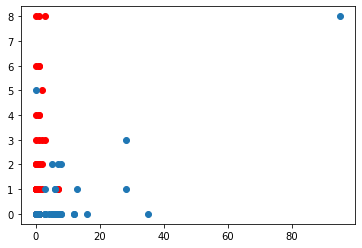

In [57]:
import numpy as np
import matplotlib.pyplot as plt

N = 50
x = np.array(X_f)
x_n = np.array(X_n)
y = np.random.rand()

plt.scatter(x[:,0],x[:,1],c='r')
plt.scatter(x_n[:,0],x_n[:,1] )
plt.show()